In [1]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lime
import shap
import matplotlib as plot
import sklearn.metrics
import sklearn.datasets
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score

/home/teadem/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
def loadDataset(dataset):
    if dataset == "breast cancer":
        X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
    
        return X, y
    elif dataset == "wine":
        wine = sklearn.datasets.load_wine()
        X = wine.data
        y = wine.target
        target_names = wine.target_names
        feature_names = wine.feature_names

        return X,y,target_names,feature_names
    else: 
        return None

In [3]:
def split_train_test(X,y,test_size=0.3,randomstate=42,scale=False):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=randomstate)
    return X_train,X_test,y_train,y_test


In [4]:
def train_model(model, X,y):
    if model == "Logistic Regression":
        lr = LogisticRegression(max_iter=10000)
        lr.fit(X,y)
        return lr
    elif model == "Random Forest Classifier":
        rf_c = RandomForestClassifier()
        rf_c.fit(X,y)
        return rf_c
    elif model == "SVC":
        svc = SVC(
            kernel = 'rbf',
            C=1,
            probability=True,
            gamma = 0.1,
            decision_function_shape='ovr',  # n_cls trained with data from one class as postive and remainder of data as neg
            random_state = 0,
        )
        svc.fit(X,y)
        return svc
    else:
        return None


In [5]:

def Explanation(explainer,model,X,X_ref):
    
    if explainer == "SHAP":
        exp = shap.Explainer(model, X_ref)
        shap_vals = exp(X)
        base_val = shap_vals.base_values 
        return shap_vals,base_val
    elif explainer == "Kernel SHAP":
        exp = shap.KernelExplainer(model, X_ref)
        shap_vals = exp.shap_values(X)
        expected_val = exp.expected_value
        return shap_vals,expected_val
    elif explainer == "Tree SHAP":
        exp = shap.TreeExplainer(model,X_ref)
        shap_vals = exp(X)
        return shap_vals
    elif explainer == "LIME":
       
        lime_exp = lime.lime_tabular.LimeTabularExplainer(
            X,
            mode='classification') 
        exp_lime = []
        for x in X:
            ex = lime_exp.explain_instance(x, 
                model, num_features=x.shape[0])
            exp_lime.append(x)
        return exp_lime
    elif explainer == "LIME-SHAP":
        exp_lime = []
        
        lime_explainer_shap = shap.other.LimeTabular(model,X,mode = 'classification')
        lime_attribs = lime_explainer_shap.attributions(X,num_features=X.shape[1])
        return lime_attribs
    else:
        return None
'''lime_exp = lime.lime_tabular.LimeTabularExplainer(
    X_train_np,
    feature_names=columns ,
    class_names=['feature_names'], 
    verbose=True, 
    mode='regression')'''

"lime_exp = lime.lime_tabular.LimeTabularExplainer(\n    X_train_np,\n    feature_names=columns ,\n    class_names=['feature_names'], \n    verbose=True, \n    mode='regression')"

In [6]:
def visualize(model,X, shap_value,type_of_Vis,local_global):
    if local_global == "local":
        shap.initjs()
        if type_of_Vis == "force":
            shap.plots.force(shap_value)
        
    elif local_global == "global":
        if type_of_Vis == "plot bar":
            shap.plots.bar(shap_value)
        elif type_of_Vis == "heatmap":
            shap.plots.heatmap(shap_value)
        elif type_of_Vis == "summary plot":
            shap.summary_plot(shap_value, X)


In [7]:
import matplotlib.pyplot as pp
def plot(x):
  pp.plot(x,'-o')
  pp.show()

In [8]:
# ar = np.argsort(-coefs)  #argsort returns indexes of values sorted in increasing order; so do it for negated array
#     pred_probs = np.zeros(x.shape[0])
#     for ind in np.nditer(ar):
#         x_copy = x.copy()
#         x_copy[ind] = base[ind]
#         x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
#         pred_probs[ind] = x_copy_pr[0][pred_class]

#     return -np.corrcoef(coefs, pred_probs)[0,1]

In [9]:
def faithfulness_metrics_cls(model,x,coefs,base):
    pred_class = np.argmax(model.predict_proba(np.transpose(x.reshape(-1,1))), axis=1)[0]
    ar = np.argsort(-coefs)  #argsort returns indexes of values sorted in increasing order; so do it for negated array
    pred_probs = np.zeros(x.shape[0])
    diff = []
    for ind in np.nditer(ar):
        x_copy = x.copy()
        x_copy[ind] = base[ind]
        
        x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
        pred_probs[ind] = x_copy_pr[0][pred_class]
        # print(pred_probs)
        # print(pred_class)

    return -np.corrcoef(coefs, pred_probs)[0,1]

In [10]:
def monotonicity(model, x, coef, base):
    pred_class = np.argmax(model.predict_proba(np.transpose(x.reshape(1,-1))), axis=1)[0]
    x_copy = base.copy()

    #find indexs of coefficients in increasing order of value
    ar = np.argsort(coefs)
    pred_probs = np.zeros(x.shape[0])
    for ind in np.nditer(ar):
        x_copy[ind] = x[ind]
        x_copy_pr = model.predict_proba(np.transpose(x_copy.reshape(1,-1)))
        pred_probs[ind] = x_copy_pr[0][pred_class]

    return -np.all(np.diff(pred_probs[ar]) >= 0)

In [18]:
x=np.array([[1,2,3],[2,3,4]])
x[1:,]

array([[2, 3, 4]])

In [12]:
base = np.mean(x, axis=0)
base

array([1.5, 2.5, 3.5])

In [42]:
def metrics(model,X,shap_val,explainer_type,metrics_type,dataset):
    # cols = X.columns
    # if dataset == "boston":
    #   base1 = X[cols].mean()
    #   base1['ZN'] = int(round(X['ZN'].mean()))
    #   base1['CHAS'] = 0
    #   base1['RAD'] = int(round(X['RAD'].mean()))
    #   base = base1.values
    # else:
    base = np.mean(X,axis=0)
    if metrics_type == "faithfulness":
        faithfulness = []
        if explainer_type == "shap":
            for i in range(X.shape[0]):
                x = X[i,:]
                
                # print(shap_val[i])
                coefs = shap_val[i].values
                f = faithfulness_metrics_cls(model, x, coefs, base)
                # print(f)
                faithfulness.append(f)
        elif explainer_type == "kernel shap":
            for i in range(X.shape[0]):
                x = X[i,:]
                # print(shap_val[i])
                coefs = shap_val[i]
                f = faithfulness_metrics_cls(model, x, coefs, base)
                # print(f)
                faithfulness.append(f)
        elif explainer_type == "lime":
            for i in range(X.shape[0]):
                x = X[i,:]
                coefs = shap_val[i]
                f = faithfulness_metrics_cls(model, x, coefs, base)
                # print(f)
                faithfulness.append(f)
        plot(faithfulness)
        return np.array(faithfulness).mean()
    elif metrics_type == "monotonicity":
        monotonicity = []
        if explainer_type == "shap":
            for i in range(X.shape[0]):
                x = X[i,:]
                coefs = shap_val.values[i]
                f = monotonicity(model, x, coefs, base)
                monotonicity.append(f)
        elif explainer_type == "lime":
            for i in range(X.shape[0]):
                x = X[i,:]
                coefs = shap_val[i]
                f = monotonicity(model, x, coefs, base)
                monotonicity.append(f)
        return monotonicity

In [26]:
def Main(dataset):
    if dataset == "wine":
        X,y,target_names,feature_names = loadDataset(dataset)
    else:
        X,y = loadDataset(dataset)
    
    sc = StandardScaler()
    X_scaled = sc.fit_transform(X)
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    X_trainS,X_testS,y_trainS,y_testS = train_test_split(X_scaled,y)

    LR_model = train_model("Logistic Regression",X_train,y_train)
    RF_model = train_model("Random Forest Classifier",X_train,y_train)
    SVC_model = train_model("SVC",X_trainS,y_trainS)

    print('R2 for Train)', RF_model.score( X_train, y_train ))
    print('R2 for Test (cross validation)', RF_model.score(X_test, y_test))
    
    print('R2 for Train)', LR_model.score( X_train, y_train ))
    print('R2 for Test (cross validation)', LR_model.score(X_test, y_test))
    
    print('R2 for Train)', SVC_model.score( X_trainS, y_trainS))
    
    predict_fnLR = lambda x:LR_model.predict_proba(x)[:,1]
    predict_fnRF = lambda x:RF_model.predict_proba(x)[:,1]
    predict_fnSVC = SVC_model.decision_function 

    X100 = shap.maskers.Independent(X, max_samples=100)
    X100_ = shap.utils.sample(X, 100)
    
    LR_shap,LR_baseVal = Explanation("SHAP",predict_fnLR,X_test[:50,],X100)
    LR_shap_k,LR_expected_val_k = Explanation("Kernel SHAP",predict_fnLR,X_test[:50,],X100_)
    LR_lime1 = Explanation("LIME",LR_model.predict_proba,X_test,X100)
    
    RF_shap, RF_baseVal = Explanation("SHAP",predict_fnRF,X_test[:50,],X100)
    RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",predict_fnRF,X_test[:50,],X100_)
    RF_lime1 = Explanation("LIME",RF_model.predict_proba,X_test,X100)
    
    SVC_shap, SVC_baseVal = Explanation("SHAP",predict_fnSVC,X_testS[:50,],X100)
    SVC_shap_k,SVC_expected_val_k = Explanation("Kernel SHAP",predict_fnSVC,X_testS[:50,],X100_)
    SVC_lime1 = Explanation("LIME",SVC_model.predict_proba,X_testS,X100)
    
    ################### evaluation#####################
    
    #faithfulness
    faithfulness_LR_shap= metrics(model=LR_model,X=X_test[:50,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
    print("Mean Faithfulness for shap Logistic reg:",np.mean(np.array(faithfulness_LR_shap)))
    faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test[:50,],shap_val=LR_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset="dataset")
    print("Mean Faithfulness for kernel shap Logistic reg:",np.mean(np.array(faithfulness_LR_shap_k)))
    faithfulness_LR_lime = metrics(model=LR_model,X=X_test[:50,],shap_val=LR_lime1,explainer_type="lime",metrics_type="faithfulness",dataset="dataset")
    print("Mean Faithfulness for lime Logistic Reg:",np.mean(np.array(faithfulness_LR_lime)))
    faithfulness_RF_shap = metrics(model=RF_model,X=X_test[:50,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
    print("Mean Faithfulness for shap RF Classification:",np.mean(np.array(faithfulness_RF_shap)))
    faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test[:50,],shap_val=RF_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset="dataset")
    print("Mean Faithfulness for kernel shap RF Classification:",np.mean(np.array(faithfulness_RF_shap_k)))
    faithfulness_RF_lime = metrics(model=LR_model,X=X_test[:50,],shap_val=RF_lime1,explainer_type="lime",metrics_type="faithfulness",dataset="dataset")
    print("Mean Faithfulness for lime RF Classification:",np.mean(np.array(faithfulness_RF_lime)))
    #TODO svc
    
    

R2 for Train) 1.0
R2 for Test (cross validation) 1.0
R2 for Train) 0.9924812030075187
R2 for Test (cross validation) 1.0
R2 for Train) 1.0


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

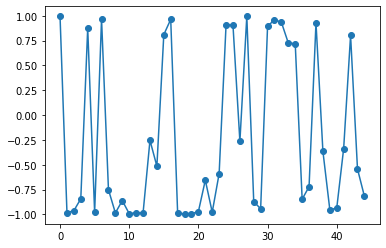

Mean Faithfulness for shap Logistic reg: -0.23295104452503865


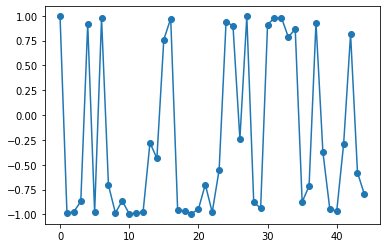

Mean Faithfulness for kernel shap Logistic reg: -0.22232019591959074


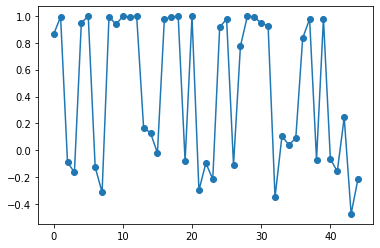

Mean Faithfulness for lime Logistic Reg: 0.44323174678959615


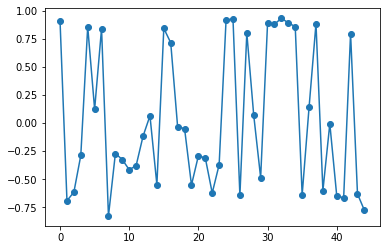

Mean Faithfulness for shap RF Classification: 0.03451640846327556


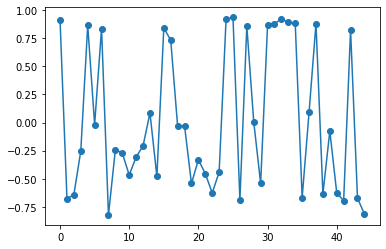

Mean Faithfulness for kernel shap RF Classification: 0.021785090436453436


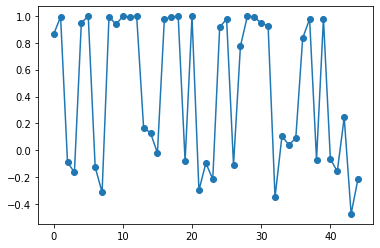

Mean Faithfulness for lime RF Classification: 0.44323174678959615


In [27]:
dataset = "wine"
Main(dataset)

In [43]:
dataset1 = "breast cancer"

In [ ]:
Main(dataset1)

R2 for Train) 1.0
R2 for Test (cross validation) 0.951048951048951
R2 for Train) 0.9577464788732394
R2 for Test (cross validation) 0.958041958041958
R2 for Train) 0.9906103286384976


  0%|          | 0/50 [00:00<?, ?it/s]

In [28]:
X,y,target_names,feature_names = loadDataset("wine")
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_trainS,X_testS,y_trainS,y_testS = train_test_split(X_scaled,y)

In [29]:
X.shape

(178, 13)

In [30]:
X_train[10:,].shape

(123, 13)

In [31]:
LR_model = train_model("Logistic Regression",X_train,y_train)
RF_model = train_model("Random Forest Classifier",X_train,y_train)
SVC_model = train_model("SVC",X_trainS,y_trainS)

In [32]:
print('R2 for Train)', RF_model.score( X_train, y_train ))
print('R2 for Test (cross validation)', RF_model.score(X_test, y_test))

R2 for Train) 1.0
R2 for Test (cross validation) 0.9555555555555556


In [33]:
print('R2 for Train)', LR_model.score( X_train, y_train ))
print('R2 for Test (cross validation)', LR_model.score(X_test, y_test))

R2 for Train) 1.0
R2 for Test (cross validation) 0.9333333333333333


In [34]:
print('R2 for Train)', SVC_model.score( X_trainS, y_trainS))
# print('R2 for Test (cross validation)', r2_score(y_testS, sc.inverse_transform(SVC_model.predict(X_testS))))


R2 for Train) 1.0


In [35]:
predict_fnLR = lambda x:LR_model.predict_proba(x)[:,1]
predict_fnRF = lambda x:RF_model.predict_proba(x)[:,1]
predict_fnSVC = SVC_model.decision_function 

In [36]:
predict_fnSVC1 = SVC_model.predict_proba (np.transpose(X_testS[0].reshape(-1, 1)) )
predict_fnSVC1[:,1]

array([0.02093997])

In [37]:
X100 = shap.maskers.Independent(X, max_samples=100)
X100_ = shap.utils.sample(X, 100)

LR_shap,RF_expected_val = Explanation("Kernel SHAP",predict_fnLR,X_test[10:,],X100_)




  0%|          | 0/35 [00:00<?, ?it/s]

In [28]:
LR_lime1 = Explanation("LIME",LR_model.predict_proba,X_test,X100)
# LR_lime = Explanation("LIME-SHAP",predict_fnLR,X_test,X100)

In [29]:
X_10 = shap.maskers.Independent(X, max_samples=10)

In [30]:
# LR_lime = Explanation("LIME-SHAP",predict_fnLR,X_test[:10,],X_10)

In [38]:
X100 = shap.utils.sample(X, 1000)
LR_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",predict_fnLR,X_test[10:,],X100)


Using 178 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/35 [00:00<?, ?it/s]

In [39]:
LR_shap,LR_baseVal = Explanation("SHAP",predict_fnLR,X_test[10:,],X100)

In [33]:
RF_shap, RF_baseVal = Explanation("SHAP",predict_fnRF,X_test[10:,],X100)
RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",predict_fnRF,X_test[10:,],X100)


Using 178 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/35 [00:00<?, ?it/s]

In [34]:
RF_lime1 = Explanation("LIME",RF_model.predict_proba,X_test,X100)


In [35]:
# RF_lime = Explanation("LIME-SHAP",predict_fnRF,X_test,X100)

In [36]:
SVC_shap, SVC_baseVal = Explanation("SHAP",predict_fnSVC,X_testS[10:,],X100)
SVC_shap_k,SVC_expected_val_k = Explanation("Kernel SHAP",predict_fnSVC,X_testS[10:,],X100)


Using 178 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/35 [00:00<?, ?it/s]

In [37]:
SVC_lime1 = Explanation("LIME",SVC_model.predict_proba,X_testS,X100)
# SVC_lime = Explanation("LIME-SHAP",predict_fnSVC,X_testS,X100)

In [38]:
print((X_test[0].reshape(-1,1)).shape)

(13, 1)


In [39]:
X_test.shape

(45, 13)

In [40]:
LR_model.predict_proba(np.transpose(X_test[0].reshape(-1,1)))

array([[0.98323381, 0.0154647 , 0.00130149]])

In [41]:
RF_shap[0].shape

(13,)

In [42]:
LR_shap[0].shape

(13,)

In [43]:
LR_shap_k[0].shape

(13,)

In [44]:
RF_shap_k[0].shape

(13,)

In [45]:
SVC_shap[0].shape

(13, 3)

In [46]:
SVC_shap_k[0].shape

(35, 13)

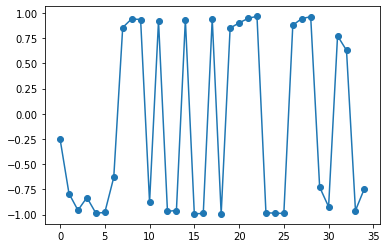

In [40]:
faithfulness_LR_shap= metrics(model=LR_model,X=X_test[10:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
# faithfulness_RF_shap = metrics(model=RF_model,X=X_test[10:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
# faithfulness_RF_lime = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
# faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test[10:,],shap_val=LR_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
# faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")

# monotonicity_LR_lime = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
# monotonicity_RF_shap = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
# monotoni

In [65]:
np.mean(np.array(faithfulness_LR_shap))

-0.13183368610140456

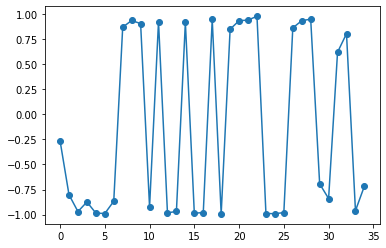

In [41]:
faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test[10:,],shap_val=LR_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset="dataset")


In [ ]:
def faithfulness_metrics_cls(model,x,coefs,base):
    pred_class = np.argmax(model.predict_proba(np.transpose(x.reshape(-1,1))), axis=1)[0]
    ar = np.argsort(-coefs)  #argsort returns indexes of values sorted in increasing order; so do it for negated array
    pred_probs = np.zeros(x.shape[0])
    diff = []
    for ind in np.nditer(ar):
        x_copy = x.copy()
        d = x_copy[ind]-base[ind]
        if d<0:
            diff.append(-1)
        else:
            diff.append(1)
        x_copy[ind] = base[ind]
        
        x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
        pred_probs[ind] = x_copy_pr[0][pred_class]
        # print(pred_probs)
        # print(pred_class)

    return -np.corrcoef(np.array(diff)*coefs, pred_probs)[0,1]

In [66]:
np.mean(np.array(faithfulness_LR_shap_k))

-0.15884822922728817

In [56]:
# LR_shap_k

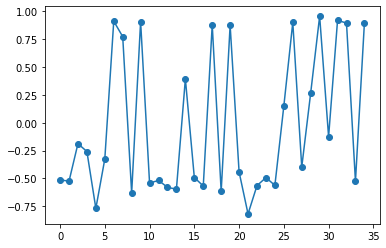

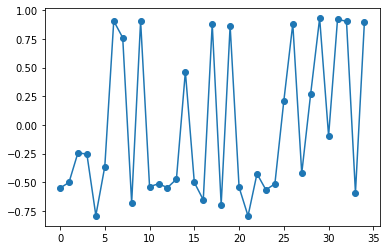

In [57]:
faithfulness_RF_shap = metrics(model=RF_model,X=X_test[10:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test[10:,],shap_val=RF_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset="dataset")


In [68]:
np.mean(np.array(faithfulness_RF_shap))

-0.0380167896335335

In [67]:
np.mean(np.array(faithfulness_RF_shap_k))

-0.04092136789680185

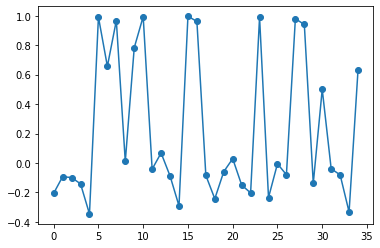

In [60]:
# faithfulness_SVC_shap = metrics(model=SVC_model,X=X_testS[10:,],shap_val=SVC_shap,explainer_type="shap",metrics_type="faithfulness",dataset="")
faithfulness_LR_lime = metrics(model=LR_model,X=X_test[10:,],shap_val=LR_lime1,explainer_type="lime",metrics_type="faithfulness",dataset="dataset")
# faithfulness_RF_shap = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
# faithfulness_RF_lime = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
# faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
# faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")

# monotonicity_LR_lime = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
# monotonicity_RF_shap = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
# monotonicity_RF_lime = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)


In [69]:
np.mean(np.array(faithfulness_LR_lime))

0.2153411196486147

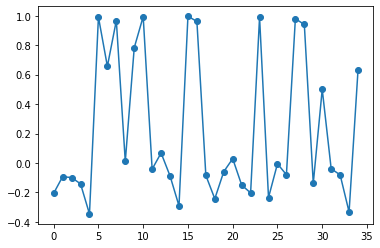

0.2153411196486147

In [71]:
faithfulness_RF_lime = metrics(model=LR_model,X=X_test[10:,],shap_val=RF_lime1,explainer_type="lime",metrics_type="faithfulness",dataset="dataset")
np.mean(np.array(faithfulness_RF_lime))

In [61]:
LR_shap[0].shape

(13,)

In [63]:
x = X_test[0]
coefs = LR_shap.values[0]
base = np.mean(X_test,axis=0)

# monotonicity(LR_model, x, coefs, base)

In [ ]:
monotonicity_LR_shap = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset="dataset")


In [ ]:
monotonicity(model, x, coefs, base)

In [ ]:
# faithfulness_LR_shap = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
faithfulness_LR_lime = metrics(model=LR_model,X=X_test[10:,],shap_val=LR_lime1,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
# faithfulness_RF_shap = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
faithfulness_RF_lime = metrics(model=RF_model,X=X_test[10:,],shap_val=RF_lime1,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
# faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
# faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

# monotonicity_LR_shap = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
# monotonicity_LR_lime = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
# monotonicity_RF_shap = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
# monotonicity_RF_lime = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)


In [ ]:
def Main(dataset):
  X,y = loadDataset(dataset)
  sc = StandardScaler()
  X_scaled = sc.fit_transform(X)
  X_train,X_test,y_train,y_test = train_test_split(X,y)
  X_trainS,X_testS,y_trainS,y_testS = train_test_split(X_scaled,y)
  
  LR_model = train_model("Logistic Regression",X_train,y_train)
  RF_model = train_model("Random Forest Classifier",X_train,y_train)
  SVC_model = train_model("SVC",X_trainS,y_trainS)

  print("====================================================================")
  print("Logistic Regression:")
  print('R2 for Train)', RF_model.score( X_train, y_train ))
  print('R2 for Test (cross validation)', RF_model.score(X_test, y_test))
  print("====================================================================")
  print("Random Forest Classifier:")
  print('R2 for Train)', LR_model.score( X_train, y_train ))
  print('R2 for Test (cross validation)', LR_model.score(X_test, y_test)) 
  print("====================================================================")
  print("SVM Classifier:")
  print('R2 for Train)', SVC_model.score( X_trainS, y_trainS))
  print("====================================================================")
  predict_fnLR = lambda x:LR_model.predict_proba(x)[:,1]
  predict_fnRF = lambda x:RF_model.predict_proba(x)[:,1]
  predict_fnSVC = SVC_model.decision_function 

  X100 = shap.maskers.Independent(X, max_samples=100)
  X_100 = shap.utils.sample(X, 1000)
  LR_shap,LR_baseVal = Explanation("SHAP",LR_model,X_test.iloc[100:,],X100)
  LR_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",LR_model,X_test.iloc[100:,],X100)
  LR_lime1 = Explanation("LIME",LR_model,X_test,X100)
  LR_lime = Explanation("LIME-SHAP",LR_model,X_test,X100)

  RF_shap, RF_baseVal = Explanation("SHAP",RF_model,X_test.iloc[100:,],X100)
  RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",RF_model,X_test.iloc[100:,],X100)
  RF_lime1 = Explanation("LIME",RF_model,X_test,X100)
  RF_lime = Explanation("LIME-SHAP",RF_model,X_test,X100)

  faithfulness_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_LR_lime = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
  faithfulness_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_RF_lime = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
  faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

  monotonicity_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_LR_lime = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
  monotonicity_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_RF_lime = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)


  print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_LR_shap)
  print("====================================================================")
  # print("faithfulness for lime explainer for Linear regression",faithfulness_LR_lime)
  print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_RF_shap)
  print("====================================================================")
  # print("faithfulness for lime explainer for Linear regression",faithfulness_RF_lime)
  print("====================================================================")
  print(monotonicity_LR_shap)
  print("====================================================================")
  # print(monotonicity_LR_lime.any())
  print("====================================================================")
  print(monotonicity_RF_shap)
  print("====================================================================")
  # print(monotonicity_RF_lime.any())
  print("====================================================================")
#monotonicity_RF_lime,faithfulness_LR_lime,faithfulness_RF_lime,monotonicity_LR_lime
  return faithfulness_RF_shap,monotonicity_LR_shap,monotonicity_RF_shap,faithfulness_LR_shap